# Privacy Risk Module

Data breaches have been on the rise, and healthcare firms such as Optum/United Healthcare are particularly vulnerable as they possess extensive Personal Identifiable Information of patients. This significantly hampers the productivity of analysts who need access to datasets, because of long wait times for data access and authorization. Synthetic Data can potentially solve the problem, but there is still a need to compare the privacy risks of synthetic data vs alternatives for businesses to understand the risk involved.

## Goal of the Privacy Risk Module

Privacy Risk is the most important problem that has led to productivity issues, because of delays in data authorization and access. Addressing this problem, we need to understand why we need to quantitatively measure privacy risk. A walkthrough on existing and new techniques to minimize privacy risk, all confront the problem that measuring privacy risk is tricky.

#### Existing and New Techniques to reduce Privacy Risk

1. **Reduce the number of columns by removing identifier columns:**


    Risks: Very common columns like SSN or Patient ID which are unique to a record need to be removed and these definitely reduce the Privacy Risk dramatically as they can be used to join with external tables and mine information. But in practice, these identifier information are not very useful in the use cases for Optum’s research initiatives. The question then becomes - what other columns do we need to drop in order to reduce our Privacy Risk? There is no way to measure which columns make a dataset sensitive.


2. **Reduce the number of rows:** 


    Risks: We still do not have a quantifiable metric to say how much of Privacy Risk was reduced. The larger risk here is that we arbitrarily remove a fraction of the dataset, this might lead to the dataset becoming less useful. We need to remove rows in a way that retains the usefulness of data, while reducing the risk. Note that every single datapoint that is retained is 100% exposed and can be used by bad actors to mine information (by joining with external tables)


3. **Synthesize new data that resembles original data**

    Risks: There is a potential that our synthetic data generation tool presents data that is still relatively close or 100% similar to our original data points if we try to maximize the utility of the dataset too much. We need a metric to still quantify the risk that we accept in these scenarios.


### The need to measure privacy

The solution to generate synthetic data has been gaining great traction, but it is still at a nascent stage in terms of research and deployment. A common problem is the idea of coming up with metrics that define the level of privacy achieved in a synthetic dataset, that are easily explainable.

We are predominantly concerned about bad actors being able to join our datasets with the synthetic dataset with outside information to gain access to our PII information. Hence, if there is an opportunity to confuse the bad actor in a way they cannot link a synthetic datapoint to an original datapoint, that is the ideal scenario for us.

**Goal of our methodology document is to define how Optum can define the Privacy Risk in a synthetically created medical dataset.** We would like to walk through the progressive evolution of a new metric/method we developed - **‘Privacy At Risk (PaR)’**, how it can be used to define risk in multiple situations, and how PaR values can be used to effectively assess situations and enable quicker data-sharing practices within Optum.


## Methodology

Our goal is to define how Optum can assess the privacy risk inherent in the synthetic data generated for distribution purposes. Our methodology revolves around the evolution of a measurement technique, starting from a naive approach to a more sophisticated approach based on the need for the level of privacy in a use case, and the level of sophistication we expect from bad actors.

### Roadmap of Privacy Risk Measurement

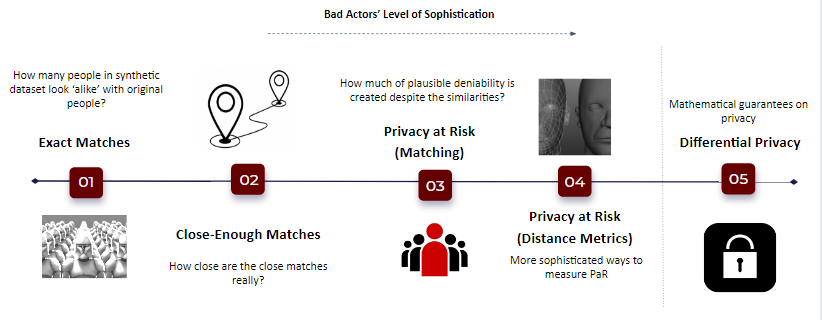

In [1]:
from IPython.display import Image
Image('roadmap.png')

As we go from 1 to 5: We become more and more conservative ie. caculate risk as if we're preparing for the worst outcome. To put in different words, they're ordered in the level of sophistication the bad actors might have.

Part 5 is Differential Privacy which we've not had the bandwidth to explore within this project. But it's a promising direction to take the project towards, because of the mathematical guarantees on Privacy that it has to offer. In this module, we focussed on more explainable metrics that can quickly be used to understand the privacy of dataset and iterate.

### 1. Privacy Risk - Exact Matches

So we have generated synthetic data. We cannot by default assume that since it's artificial data, it cannot be the same as the original data. In scenarios of overtraining models, we might get exact CLONES in Synthetic Data. This is counterproductive, because we end up exposing those individuals/records anyway. So for every original person/record - we scan the dataset to see if we find an exact match ie. clone

### 2. Privacy Risk - Closest Matches

But there is a problem with the Exact Matches Approach - our bad actors can get more sophisticated. They get to know we keep changing few values in the dataset to confuse them - and hence they would start looking at who's the closest match and use those records to re-identify people. The simple game of 'Spot the Differences' on the right explains this concept. This is what our Synthetic Data could be doing - adding more differences to the original datapoints. The more differences, we add the more we are able to protect the original information

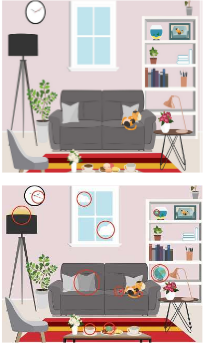

In [5]:
Image('spotdiff.png')

### 3. Privacy Risk using PaR (Privacy at Risk metric)

#### 3.1 Issue with Previous Approach

A key issue with the previous approach is that one cannot know whether 9 differing columns is ideal or poor. The answer is always depends on the context of the problem, and the level of privacy it demands. Hence, setting thresholds becomes necessary, but can be arbitrary.


#### 3.2 Privacy at Risk methodology

The Privacy At Risk Metric was developed to solve this issue. **The PaR Metric works** by leveraging the idea of confusion with respect to data records. How many datapoints in our set can be confused for with other people/other records? The higher the confusion, the lesser the chance of a person being re-identified. The focus is primarily on whether including a certain record increases the chance of exposing a person/record and the degree of the exposure.

**Pseudo Code:**

    for each person in original_dataset:
        synthetic = number of columns that differ with closest match in Synthetic Dataset
        within = number of columns that differ with closest match in Original Dataset
        atRisk = True (if within > synthetic) / False (if synthetic > within)
        lift = within/synthetic
        
        privacy_at_risk = Number of atRisk Rows x 100 / Total Number of Rows

**3.2.1 Low-Risk Situation**

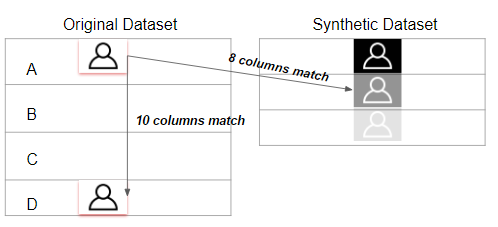

In [6]:
Image('lowrisk.png')

Let's take a look at the Low Risk Scenario above. We first assess Person A and try to find the closest match in the Synthetic Dataset. That turns out to be Record #2 - and they match on 8 columns. Now let's do one thing additionally, we look within the original dataset to find who else is similar to us - we can see that Person D is the most - matching on all the 10 columns. 

**External Similarity** is when we look at the closest (most similar) record within Synthetic Dataset and **Internal Similarity** is when we look at th closest (most similar) record within the Original Dataset

Hence, when Internal Similarity > External Similarity = Low-Risk Situation

**3.2.2 High Risk Situation**


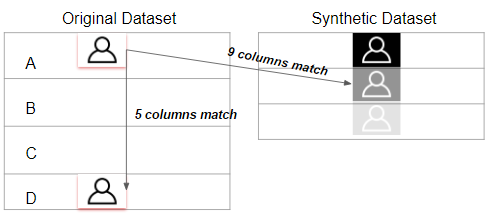

In [8]:
Image('highrisk.png')

Let's take a look at the High Risk Scenario above. We first assess Person A and try to find the closest match in the Synthetic Dataset. That turns out to be Record #2 - and they match on 9 columns now! We now look within the original dataset to find who else is similar to us - we can see that Person D is the most - matching on only 5 out of 10 columns.

Hence if a bad actor got access to synthetic dataset and hence Record #2, the bad actor would be able to connect it with Person A and not D (because D and A are not that similar). This is risky because using a synthetic record, we can trace it back to A.

Hence when External Similarity > Internal Similarity = High-Risk

**3.3 Plausble Deniability**

What does this mean for the privacy of Person A? If a bad actor were to get access to Synthetic Data and Record #2 - the bad actor could trace it back to Person A or they could trace it back to Person D cuz they're both lookalike. There's always a plausible deniability that Person A could say my record was pointing to Person D - thus their sensitive information is protected. 

**3.4 Measuring Internal Similarity in different types of datasets**

1. **Personal Information Datasets**: This follows the same approach detailed in 3.2.1 and 3.2.2
2. **Multiple Rows per Person Datasets**:This case will be dealt with differently with respect to Internal Similarity.

    In this scenario, when we compare a single record with every other record in the same Original Dataset - we are not really answering the question of whether there is another person who really resembles this person/record. The problem here is each person might have multiple records. Hence when we compute Internal Similarity, we may end up finding 'similar people' always when those are all records belonging to the same person.

    Hence the solution is to only look at records belonging to other users / patients in our use case. We use the Patient ID information to determine which records belong to which user. Hence:

    ***Internal Similarity is the distance of a given datapoint to every other datapoint belonging to a different user.***

*Summarizing,*

* Internal Similarity > External Similarity : Ideal Data Point for us; Bad actors cannot attribute a data point to a single person/original record.

* External Similarity > Internal Similarity: Risky Data Point for us; The record in synthetic dataset is so unique that the synthetic data record can only point to one user record and hence increases the privacy risk of that data point. 

* Hence **Privacy Risk = Number of Risky Points / (Number of Datapoints Total)**


Advantage: The biggest problem we solve is the need to set thresholds, because it is completely relative to the dataset.

**3.5 Interpreting PaR Analysis Results**

The table below is a sample result from a PaR analysis. The results dataframe is as the same length as the original dataset. This is because we flag original datapoints and mention if they have been put at risk because of the synthetic dataset. Hence PaR is a metric that looks at the synthetic dataset and answers the question of the degree of harm that can happen if the synthetic data was exposed. Using the original datapoints that are at Risk - we can do further analysis to see what synthetic datapoints should be addressed to 

The most important columns to look at are the 'synthetic', 'within', 'risky' and the 'lift' features.

1. Synthetic - Number of Columns that differ with the Closest Match **in synthetic dataset** for that row
2. Within - Number of Columns that differ with the Closest Match **within the original dataset** for that row
3. Risky - A boolean flag that denotes whether our PaR Analysis has flagged this point as 'At Risk' or not.
4. Risk Lift - The lift/marginal increase in Risk for that datapoint/row

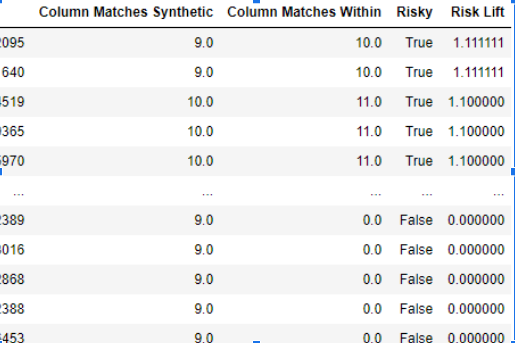

In [2]:
Image('par_results.png')

**3.6 Lift - An option to tailor Risk Measurement**

Lift = Number of Differing Columns w/ Original Dataset / Number of Differing Columns w/ Synthetic Dataset

Business use cases might not always be compatible with risk measurement where a Risky Situation is only flagged when External Similarity is simply greater than Internal Similarity. Some situations might need a metric that is proportional to the high risk involved, and hence flagging all points with Lift above 1 alone as 'Risky' may not be appropriate. 

In these case, the Lift chart can be very useful about customizing the threshold to the use case. A lower Lift Threshold would mean we catch more Risky Situations and a higher Lift Threshold (red line moves right) would mean we relax the way we measure Risk.

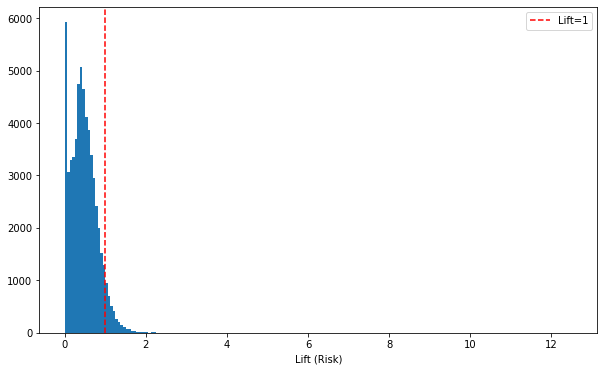

In [3]:
Image('liftchart.png')

### 4. Privacy Risk -  PaR using Distance Metrics

**4.1 Key Issue with Previus Approach** 

A key issue with the previous approach with estimating PaR using the number of column matches (previous approach) is that column matches are a more naive approach to measure privacy. What if our Synthetic Data adds a little bit of noise to every single column, and all the values are close enough to be re-identified, but they differ by a slight amount (say 0.001). Our previous approach would note that all columns differ and hence flag it as low-risk, but in reality a sophisticated bad actor might be able to note that it's not very different.

The Synthetic Data Generation process by itself brings in noise into the data, in a way that maximizes utility while also minimizing the chances of data looking closer to the original data (hence increasing the confusion aspect). Hence we need to be able to catch such situations well.

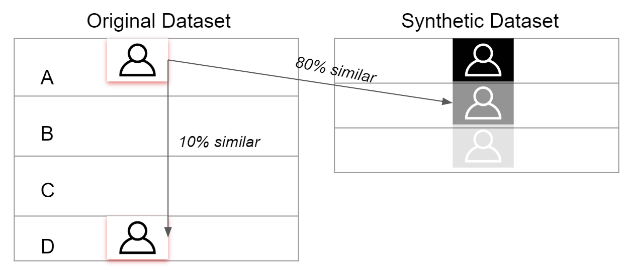

In [18]:
Image(filename='internal_d2.png')

Now we can see the closest resemblance to A inside the Original Dataset is D again, but they are only 10% similar. So that means Person A is already a stand-out unique record. On top of this, our Synthetic Dataset Record 2 is now 80% similar. So when a bad actor gets access to Record 2, there is a high chance they can connect it with Person A and nobody else without any confusion. We need to avoid these scenarios.

*Summarizing,*

* Internal Similarity > External Similarity : Ideal Data Point for us; Bad actors cannot attribute a data point to a single person/original record.

* External Similarity > Internal Similarity: Risky Data Point for us; The record in synthetic dataset is so unique that the synthetic data record can only point to one user record and hence increases the privacy risk of that data point. 

* Hence Privacy Risk = Number of Risky Points / (Number of Ideal Points + Number of Risky Points)

**4.2 Conservatism of the PaR metric**

A Privacy at Risk value of 6% does not mean 6% of the records are exposed to bad actors. It only means that there is a higher potential of a bad actor trying to interpret the synthetic information to a real record/person with 6% of the records. The inherent assumption here is that all the records in the original dataset are potentially vulnerable.


**4.3 Distance / Similarity Metrics** 

**4.3.1 Issue with Column Matches as Similarity Metric**

This can be used as an extremely conservative metric where we only look for exact matches between columns of Synthetic Data and Original Data. This can help us spot exact matches between Original Data and Synthetic Data more efficiently. It can be used in situations where the use case mandates we only worry about privacy risk in situations that are an exact match and can hence be traced back.

**4.3.2 Choice of Distance Metrics**

There are a number of Distance Metrics to choose from - Euclidean, Manhattan, Gower Distance and so on. Mahattan Distance can be useful for scenarios where we have high dimensionality (high number of columns. Gower Distance is ideal for cases where we have mixed features (categorical and continuous).

But for this analysis, we prefer to use the simple Euclidean distance after one-hot encoding the data. 

A lower value of Euclidean Distance means a higher degree of similarity and vice versa.


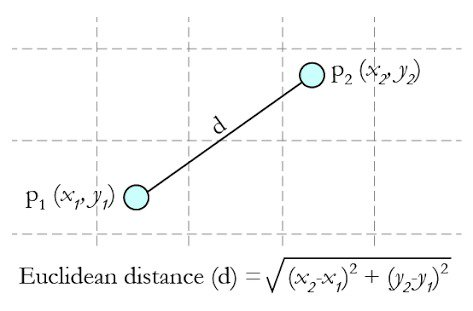

In [21]:
Image(filename='euclidean.jpeg')

We go about computing the distance between every single datapoint in the Original Dataset with every other point in the Synthetic Dataset. 


These are all the **External Distances** we obtain as a matrix of size: Length of Original Dataset x Length of Synthetic Dataset

We also need to compute the Internal Distances so that we can compare the External Distance vs Internal Distance for every real Person in the dataset.

**Internal Distances** matrix of size: Length of Original Dataset x Length of Original Dataset

**4.3.2.1 One-Hot Encoding and Normalization**

One-Hot Encoding is necessary if the metric of choice is Euclidean. Categorical Features have to be reduced down to boolean variables so that the distance can be computed. Another important step before running PaR estimates is to normalize the data. This is to ensure that when variables have different scales/magnitudes, there wouldn't be any bias propagated in the distance calculations because of that. 


**4.4 Number of Closest Neighbors**

We only wish to look at the closest/most similar records given a real person in the Original Dataset. The way bad actors can obtain information about this real person is by leveraging a very similar looking record and connect it to a real person's information outside. 

But defining 'close' is subjective. A simple approach would be to use n=1 ie. only look at the closest person in the synthetic dataset (External Similarity), and the closest other person in the original dataset (Internal Similarity)

There's always an option to extend this into a radius of close people. By setting n=5, we can always look at the closest 5 people in Original and Synthetic datasets to achieve an idea of how close are records on average.

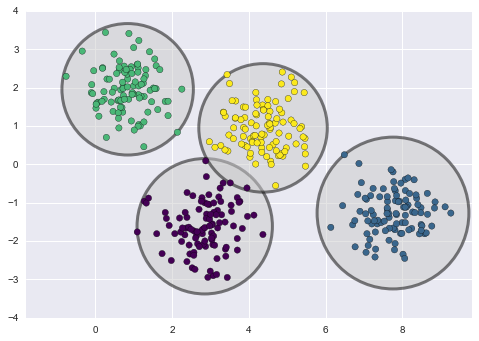

In [22]:
Image(filename='clustering.png')

**4.5 Feature Sensitivity - Weighted Distance Metrics**

Distance metrics, by default, may not account for domain knowledge about what defines similarity. Hence, a weighted distance metric might yield bette results for a defined problem, given domain knowledge.

In our scenario, we are dealing with Mortality information of Patients in ICU Wards. We know that information like Gender, Ethnicity and Age can often be used to join with External Datasets and mine patient's personally identifiable information.

Hence, we might modify the Euclidean Distance to add a lower weight for features of Gender, Age and Ethnicity. When we add lower weights for highly sensitive fields, we report higher similarity and we will be better able to catch risky situations often.


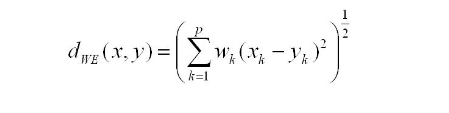

In [23]:
Image(filename='weighted.png')


### Versatility of the PaR Module

The PaR module is more driven on a broad concept and hence can be extremely tailored and used for different situations.

1. **Column Subset Analysis** - Often bad actors may have access to only 3 or 4 fields about a certain person whose information they wish to mine. The way they would go about re-identifying these individuals is by querying for these attributes and finding the closest match. More broadly, the business could only be concerned about a few columns that are highly sensitive to the business. We can filter for only these columns and estimate Privacy at Risk values.

2. **Choice of distance metric** is driven by the level of privacy needed for the use case. The way we compute similarity can be simply changed by the choice of function - be it Euclidean, Gower Distance or Cosine Similarity or Exact Matching

3. **Feature Weighting** In cases we know the sensitivity of features, we can specify the way we measure similarity by assigning weights to the features we pass into the Privacy Risk Estimator. This allows for a more tailored estimate of the risk associated with the synthetic dataset.

4. **Ability to handle different types of datasets** With the module, we can handle both Personal Information scenarios, eg: Member Data and Journey scenarios eg: Claims data. The idea of individuals within the Privacy Risk calculations can be extended to entities as well - the question becomes 'Will an entity be exposed given the synthetic data?'

### Applications of PaR Module

#### 1. Privacy Risk Removal

Using PaR analysis, we are able to flag each row of the original dataset as Risky or Not Risky. Using this information, we can look up each Risky Datapoint, understand which rows in the synthetic dataset have contributed to this, and **remove those synthetic datapoints**. We can remove anywhere between 0-100% of the Risky Datapoints, or remove datapoints ordered by Lift (how risky they are). But a key issue to note is as the Privacy at Risk value reduces, so will the Utility of the dataset. Hence careful iterations have to be made, to observe and find the ideal balance between the two

#### 2. Measuring Sensitivity of Columns

PaR analysis can also be used to understand how sensitive each column is. The approach is to pick each column, compare the PaR values including and excluding the column to come up with a Sensitivity Lift for the column. The Sensitivty Lift indicates the percentage increase in PaR values if the synthetic dataset included the column.

This can be very useful in cold-start scenarios when not much information is available about a new dataset. Data Governance team can make quantitative decisions on whether certain columns should be shared or not, based on the tradeoff between how sensitive the feature is and how necessary it is for analysts.

## Implementation

In [9]:
#Import all libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy.spatial import distance, distance_matrix
from sklearn.metrics import pairwise_distances
from datetime import datetime
import matplotlib.pyplot as plt

In [10]:
#Load up datasets
original = pd.read_csv('./mortality_full_10k.csv')
tgan = pd.read_csv('./mortality_full_10k_tgan_v1.csv')
ctgan = pd.read_csv('./mortality_full_10k_ctgan_v1.csv')

### Use Case - Patient Mortality in ICUs

This use case is inspired by Kaggle kernel (reference below) where one can predict mortality just by the number of interactions betweeen patient and hospital as predictors through count of lab tests, prescriptions, and procedures. It can be used to evaluate privacy risk with the help of Pll columns like GENDER, ETHNICITY, MARITAL_STATUS and also serves as classification problem where we have to predict if patient will expire or not for a single hospital admission. 

### Understanding the Dataset


In [11]:
original.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,GENDER,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS
0,1,23,152223,ELECTIVE,MARRIED,WHITE,0,M,0.0,0.0,8,62.0,69.0,0.0,1.0,7.0,4,180.0,208.0,12.0
1,2,23,124321,EMERGENCY,MARRIED,WHITE,0,M,1.0,6.0,10,29.0,69.0,4.0,1.0,1.0,5,0.0,221.0,17.0
2,3,24,161859,EMERGENCY,SINGLE,WHITE,0,M,0.0,4.0,4,2.0,26.0,0.0,0.0,6.0,3,50.0,99.0,5.0
3,4,25,129635,EMERGENCY,MARRIED,WHITE,0,M,0.0,4.0,4,59.0,67.0,0.0,2.0,9.0,4,483.0,315.0,20.0
4,5,26,197661,EMERGENCY,SINGLE,UNKNOWN/NOT SPECIFIED,0,M,0.0,5.0,9,15.0,49.0,0.0,10.0,2.0,4,49.0,184.0,13.0


In [12]:
tgan.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,GENDER,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS
0,0,4512,196271,EMERGENCY,WIDOWED,WHITE,0,M,-0.002,13.417417,9.000595,16.670625,-0.000036,0.002,15.997736,3.052571,2.801335,152.093421,666.279774,45.885442
1,1,109,196271,EMERGENCY,MARRIED,WHITE,0,M,-0.002,43.403188,9.000409,124.652009,185.131886,0.002,35.896967,9.386045,8.584713,2006.907087,1326.229381,81.273574
2,2,7333,105996,NEWBORN,UNKNOWN (DEFAULT),UNKNOWN/NOT SPECIFIED,0,F,-0.002,0.000186,6.227305,7.443537,-0.000314,0.002,0.511756,0.048430,3.893407,171.152481,95.848552,9.416560
3,3,4512,137713,ELECTIVE,MARRIED,WHITE,0,M,0.998,2.493189,13.593073,270.637304,207.531169,0.002,17.837617,6.380905,4.160944,877.651143,1249.143054,24.045799
4,4,7333,105996,EMERGENCY,MARRIED,WHITE,0,F,-0.002,34.702434,13.496426,5.831728,57.939994,0.002,-0.117796,2.836059,4.396360,-0.000758,124.250802,-0.076892


In [13]:
#Round all numerical columns in TGAN dataset
tgan = tgan.apply(lambda x: round(x) if x.name in ['NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS'] else x)
tgan.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,GENDER,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS
0,0,4512,196271,EMERGENCY,WIDOWED,WHITE,0,M,-0.0,13.0,9.0,17.0,-0.0,0.0,16.0,3.0,3.0,152.0,666.0,46.0
1,1,109,196271,EMERGENCY,MARRIED,WHITE,0,M,-0.0,43.0,9.0,125.0,185.0,0.0,36.0,9.0,9.0,2007.0,1326.0,81.0
2,2,7333,105996,NEWBORN,UNKNOWN (DEFAULT),UNKNOWN/NOT SPECIFIED,0,F,-0.0,0.0,6.0,7.0,-0.0,0.0,1.0,0.0,4.0,171.0,96.0,9.0
3,3,4512,137713,ELECTIVE,MARRIED,WHITE,0,M,1.0,2.0,14.0,271.0,208.0,0.0,18.0,6.0,4.0,878.0,1249.0,24.0
4,4,7333,105996,EMERGENCY,MARRIED,WHITE,0,F,-0.0,35.0,13.0,6.0,58.0,0.0,-0.0,3.0,4.0,-0.0,124.0,-0.0


In [14]:
#Filtering for only columns needed 

#Storing the Subject ID ie. Patient ID for use in computing Internal Similarity
original_uid = original['SUBJECT_ID'].values

original = original[['ADMISSION_TYPE', 'MARITAL_STATUS',
       'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'GENDER', 'NUMCALLOUT',
       'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS']]


tgan = tgan[['ADMISSION_TYPE',
       'MARITAL_STATUS', 'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'GENDER',
       'NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS']]

original.head()


,ADMISSION_TYPE,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG,GENDER,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS
0,ELECTIVE,MARRIED,WHITE,0,M,0.0,0.0,8,62.0,69.0,0.0,1.0,7.0,4,180.0,208.0,12.0
1,EMERGENCY,MARRIED,WHITE,0,M,1.0,6.0,10,29.0,69.0,4.0,1.0,1.0,5,0.0,221.0,17.0
2,EMERGENCY,SINGLE,WHITE,0,M,0.0,4.0,4,2.0,26.0,0.0,0.0,6.0,3,50.0,99.0,5.0
3,EMERGENCY,MARRIED,WHITE,0,M,0.0,4.0,4,59.0,67.0,0.0,2.0,9.0,4,483.0,315.0,20.0
4,EMERGENCY,SINGLE,UNKNOWN/NOT SPECIFIED,0,M,0.0,5.0,9,15.0,49.0,0.0,10.0,2.0,4,49.0,184.0,13.0


### Exact Matches Approach

#### Data Preparation - One Hot Encoding, Normalization, Categorical Column Level Mapping

In [15]:
#Prepares data for use in the Privacy Risk Calculations
#Parameters: Original Dataset, Synthetic Data, List of Columns to use
#Returns processed Original Dataset, Synthetic Dataset, Column-Levels Mapping
def prepData(original, tgan, col_list=None):
    
    
    #Select Columns from Original and Synthetic Dataset
    if col_list is not None:
        tgan = tgan[col_list]
        original = original[col_list]
    
    #One-Hot Encode and Normalize the Original Dataset    
    x = pd.get_dummies(original).values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    original_df = pd.DataFrame(x_scaled)
    original_df.columns = pd.get_dummies(original).columns
    
    #One-Hot Encode and Normalize the Synthetic Dataset 
    x = pd.get_dummies(tgan).values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    synth_df = pd.DataFrame(x_scaled)
    synth_df.columns = pd.get_dummies(tgan).columns

    #Number of Categorical Feature Levels that were dropped because Synthetic Dataset did not report them    
    print("{0} columns levels were dropped because they were not observed in synthetic data ".format(str(len(original_df.columns) - len(synth_df.columns))))
    
    #Adding column names back
    synth_df.columns = pd.get_dummies(synth_df).columns
    original_df = original_df[synth_df.columns]
     
        
    #Feature - Feature Level Mapping (Useful to map One-Hot Encoded feature levels and associate it to a certain feature)    
    col_mapping = {}
    
    if col_list is None:
        for col in original.columns:

            col_mapping[col] = [x for x in original_df.columns if x.startswith(col)]
    else:
        for col in col_list:
            col_mapping[col] = [x for x in original_df.columns if x.startswith(col)]  
          
          
    return original_df, synth_df, col_mapping
    
    

In [16]:

#Round all numerical columns in TGAN dataset
tgan = tgan.apply(lambda x: round(x) if x.name in ['NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS'] else x)
tgan.head()

ctgan = ctgan.apply(lambda x: round(x) if x.name in ['NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS'] else x)
ctgan.head()

#Filtering for only columns needed 

original = original[['ADMISSION_TYPE', 'MARITAL_STATUS',
       'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'GENDER', 'NUMCALLOUT',
       'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS']]


ctgan = ctgan[['ADMISSION_TYPE',
       'MARITAL_STATUS', 'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'GENDER',
       'NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS']]
tgan = tgan[['ADMISSION_TYPE',
       'MARITAL_STATUS', 'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'GENDER',
       'NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS']]

original.head()

#Prepare Data for PaR estimation
original_df_tgan, synth_df_tgan, col_mapping = prepData(original, tgan, col_list = None)

#Dispose the raw data to clear memory
del tgan

#Prepare Data for PaR estimation
original_df_ctgan, synth_df_ctgan, col_mapping = prepData(original, ctgan, col_list = None)

#Dispose the raw data to clear memory
del original, ctgan


18 columns levels were dropped because they were not observed in synthetic data 
1 columns levels were dropped because they were not observed in synthetic data 


In [17]:
#Parameters: Original Dataset, Synthetic Dataset, Number of Closest Points to Analyze, Original IDs/Indexes, Verbose Flag

def findMatches(x, y):
    return len(x) - np.sum(x == y)


def estimatePARExactMatch(original_df, synth_df, top_n, original_uid = None, verbose=0 ):
    
    #Timer
    now = datetime.now()
    
    #Compute External Distances
    externals = pairwise_distances(np.asarray(original_df), np.asarray(synth_df), metric = findMatches, n_jobs=-1)
    del synth_df
    externalDistance = [np.sort(externals[i])[:top_n].mean() for i in range(0, len(original_df))]
    del externals
    now3 = datetime.now()
    if verbose == 1:
        print('External Similarities Completed: Time: {0}'.format(str(now3-now)))
    
    #Compute Internal Distances
    withins = pairwise_distances(np.asarray(original_df), np.asarray(original_df), metric=findMatches, n_jobs=-1)
    
    #Handling the Patient Journey vs Patient Info type of datasets wrt Internal Similarity
    if original_uid is not None:
        #Track uids
        original_uidf = pd.DataFrame({'uid':original_uid, 'index':original_df.index})
        uidDict = []
        for id in original_uidf.uid.unique():
            uidDict.append(original_uidf[original_uidf.uid==id]['index'].values)
            
        del original_uidf
        
        #Track all records associated with this patient, remove and compare only to others.
        withinDistance = [np.sort(np.delete(withins[i], [v for v in uidDict if i in v][0]))[:top_n].mean() for i in range(0, len(original_df))]
        del withins
        
    else:
        withinDistance = [np.sort(np.delete(withins[i], i))[:top_n].mean() for i in range(0, len(original_df))]
        del withins
        
    now2 = datetime.now()
    if verbose == 1:
        print('Internal Similarities Completed: Time: {0}'.format(str(now2-now)))
    
    #Add all info into a results dataset
    df_d = pd.DataFrame()
    df_d['synthetic'] = externalDistance #d_synthetics
    df_d['within'] = withinDistance #d_withins
    
    # 'Closer' variable tells whether Within Similarity is lower than External Similarity ie. Internal Distance greater than
    # External - Closer being 1 means this is a risky datapoint.
    df_d['closer'] = df_d.within >= df_d.synthetic
    
    #Lift measures the increase in Risk as a ratio of Internal Distance / External Distance. A Lift < 1 means not Risky. 
    #Higher values of Lift mean those datapoints in Original Dataset are at a risk of being re-identified
    df_d['lift'] = df_d.within / df_d.synthetic
    
    #Report all the At Risk IDs in Original Dataset
    atRiskIds = df_d[df_d['closer']==True].sort_values(by="lift", ascending=False).index
    
    now4 = datetime.now()
    if verbose == 1:
        print("Total Time:{0}".format(str(now4-now)))
    
    #Compute the Privacy At Risk Value
    par = df_d['closer'].mean()*100
    print("Privacy At Risk: {0}% ".format(par))
    
    return df_d, atRiskIds, par, now4-now


In [18]:
#TGAN Analysis
results_t, atrisk_t, par_t, time_t = estimatePARExactMatch(original_df_tgan, synth_df_tgan, 1, original_uid=original_uid, verbose=1)

External Similarities Completed: Time: 0:11:26.324615
Internal Similarities Completed: Time: 0:26:41.341530
Total Time:0:26:41.372776
Privacy At Risk: 1.02% 


In [19]:
#CT-GAN Analysis
results_ct, atrisk_ct, par_ct, time_ct = estimatePARExactMatch(original_df_tgan, synth_df_ctgan[synth_df_tgan.columns], 1, original_uid=original_uid, verbose=1)

External Similarities Completed: Time: 0:11:48.733858
Internal Similarities Completed: Time: 0:26:58.294220
Total Time:0:26:58.309845
Privacy At Risk: 0.62% 


Exact Match Checks

In [22]:
#Show all datapoints that have an exact match in Synthetic Dataset
results_t[results_t.synthetic==0]

,synthetic,within,closer,lift


In [24]:
results_ct[results_ct.synthetic==0]

,synthetic,within,closer,lift


We can observe both T-GAN and CT-GAN Synthetic Data had 0% Exact Matches. The synthetic data generating processes perform good on this front.

### Closest Matches Approach

In [27]:
results_t[['synthetic']].head()

,synthetic
0,9.0
1,12.0
2,9.0
3,9.0
4,10.0


The 'synthetic' column shows the closest synthetic record for the original datapoint and how many columns differed. We know that in no case we have an exact match ie. differing columns = 0. The higher the number of differing columns, more the privacy for our original data

Hence we would want to look at the average number of differing columns

In [28]:
results_t[['synthetic']].mean()

synthetic    9.6103
dtype: float64

In [29]:
results_ct[['synthetic']].mean()

synthetic    9.9574
dtype: float64

On average, every datapoint in T-GAN and CT-GAN had 9 different values/columns compared to the original datapoint. This is re-assuring because, the **closest** datapoint in the synthetic dataset varied on 9 columns on average, hence our synthetic data is quite different while retaining statistical utility.

### Privacy at Risk (Column Matches)

Now that we've looked at the Average Number of Differing Columns for T-GAN and CT-GAN, there is no way for us to determine if 9 differing columns out of 37 is good or bad. Setting thresholds can be difficult. This is a problem the Privacy at Risk metric can fix.

In [34]:
#PaR for T-GAN
results_t.closer.mean()*100

1.02

In [35]:
#PaR for T-GAN
results_ct.closer.mean()*100

0.62

Our PaR values for T-GAN turned to be 1.02% and 0.62% for CT-GAN. CT-GAN provides marginally better privacy in the synthetic data compared to T-GAN

**Interpretation** For T-GAN: Given the T-GAN Synthetic Data reaches a bad actor, 1.02% of the original dataset/patients could be re-identified/exposed.

**Lift Charts**

We can see very few points lie above a lift of 1. The highest prominence of Lift is around 0.7 ie. We have higher Similarity internally compared to the Synthetic dataset. CT-GAN results are similar.

Text(0.5, 1.0, 'T-GAN: Lift Analysis')

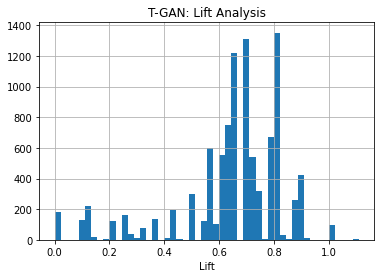

In [42]:
results_t.lift.hist(bins=50)
plt.xlabel('Lift')
plt.title('T-GAN: Lift Analysis')

Text(0.5, 1.0, 'CT-GAN: Lift Analysis')

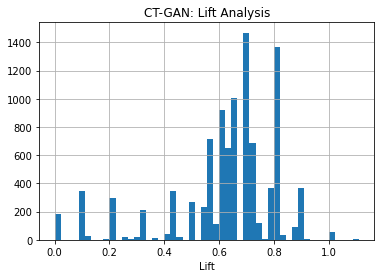

In [43]:
results_ct.lift.hist(bins=50)
plt.xlabel('Lift')
plt.title('CT-GAN: Lift Analysis')

### Privacy At Risk (Distance Metrics)

In [8]:
#Prepare Data for PaR estimation
original_df, synth_df, col_mapping = prepData(original, tgan, col_list = None)

#Dispose the raw data to clear memory
del original, tgan

34 columns levels were dropped because they were not observed in synthetic data 


In [9]:
#Check if all columns are the same in both datasets
original_df.columns == synth_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [3]:
#Parameters: Original Dataset, Synthetic Dataset, Number of Closest Points to Analyze, Original IDs/Indexes, Verbose Flag

def findMatches(x, y):
    return np.sum(x == y)


def estimatePAR(original_df, synth_df, top_n, original_uid = None, verbose=0 ):
    
    #Timer
    now = datetime.now()
    
    #Compute External Distances
    externals = pairwise_distances(np.asarray(original_df), np.asarray(synth_df), n_jobs=-1)
    del synth_df
    externalDistance = [np.sort(externals[i])[:top_n].mean() for i in range(0, len(original_df))]
    del externals
    now3 = datetime.now()
    if verbose == 1:
        print('External Similarities Completed: Time: {0}'.format(str(now3-now)))
    
    #Compute Internal Distances
    withins = pairwise_distances(np.asarray(original_df), np.asarray(original_df) )
    
    #Handling the Patient Journey vs Patient Info type of datasets wrt Internal Similarity
    if original_uid is not None:
        #Track uids
        original_uidf = pd.DataFrame({'uid':original_uid, 'index':original_df.index})
        uidDict = []
        for id in original_uidf.uid.unique():
            uidDict.append(original_uidf[original_uidf.uid==id]['index'].values)
            
        del original_uidf
        
        #Track all records associated with this patient, remove and compare only to others.
        withinDistance = [np.sort(np.delete(withins[i], [v for v in uidDict if i in v][0]))[:top_n].mean() for i in range(0, len(original_df))]
        del withins
        
    else:
        withinDistance = [np.sort(np.delete(withins[i], i))[:top_n].mean() for i in range(0, len(original_df))]
        del withins
        
    now2 = datetime.now()
    if verbose == 1:
        print('Internal Similarities Completed: Time: {0}'.format(str(now2-now)))
    
    #Add all info into a results dataset
    df_d = pd.DataFrame()
    df_d['synthetic'] = externalDistance #d_synthetics
    df_d['within'] = withinDistance #d_withins
    
    # 'Closer' variable tells whether Within Similarity is lower than External Similarity ie. Internal Distance greater than
    # External - Closer being 1 means this is a risky datapoint.
    df_d['closer'] = df_d.within >= df_d.synthetic
    
    #Lift measures the increase in Risk as a ratio of Internal Distance / External Distance. A Lift < 1 means not Risky. 
    #Higher values of Lift mean those datapoints in Original Dataset are at a risk of being re-identified
    df_d['lift'] = df_d.within / df_d.synthetic
    
    #Report all the At Risk IDs in Original Dataset
    atRiskIds = df_d[df_d['closer']==True].sort_values(by="lift", ascending=False).index
    
    now4 = datetime.now()
    if verbose == 1:
        print("Total Time:{0}".format(str(now4-now)))
    
    #Compute the Privacy At Risk Value
    par = df_d['closer'].mean()*100
    print("Privacy At Risk: {0}% ".format(par))
    
    return df_d, atRiskIds, par, now4-now


In [12]:
results2, atrisk2, par2, time2 = estimatePAR(original_df, synth_df, 1, original_uid=None, verbose=1)

External Similarities Completed: Time: 0:06:45.516049
Internal Similarities Completed: Time: 0:12:36.220353
Total Time:0:12:36.282866
Privacy At Risk: 6.143176885512751% 


In [14]:
results2.to_csv('results-tgan.csv')
pd.DataFrame({'atrisk':atrisk2}).to_csv('results-tgan-atrisk.csv')
del results2, atrisk2

Here we can see the results. The Privacy At Risk value for the synthetic data generation turns out to be 6.2%. This means that conservatively, 6.2% of the people/records in Original Dataset can potentially be re-identified back to the original information using our synthetic dataset. Hence, the objective always would be to reduce the Privacy At Risk value while maximizing utility.

We can also observe the AtRisk variable. This gives us the list of Original Datapoints/People that can be potentially exposed based on the PaR calculation. We leverage this later to reduce the PaR for the process.

#### Distance Density Plots for Risky Scenarios vs Safe Scenarios

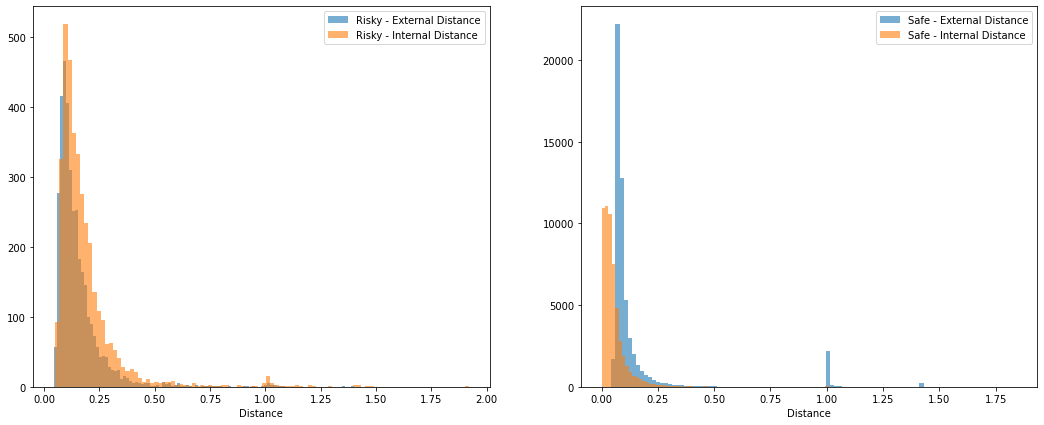

In [128]:
results = pd.read_csv('results-tgan.csv').sort_values(by='lift', ascending=False)
risky = results[results.closer==1]
safe = results[results.closer==0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(risky.synthetic, 100, alpha=0.6, label='Risky - External Distance')
ax1.hist(risky.within, 100, alpha=0.6, label="Risky - Internal Distance")
ax1.set_xlabel('Distance')
ax1.legend()
ax2.hist(safe.synthetic, 100, alpha=0.6, label="Safe - External Distance")
ax2.hist(safe.within, 100, alpha=0.6, label="Safe - Internal Distance")
ax2.set_xlabel('Distance')
ax2.legend()


We can observe that there is signficant overlap between the External and Internal Distances, meaning they're too close to call. Using a Synthetic Dataset point, one would be able to infer the original person's information in these cases

Whereas for the Safe Datapoints, we can observe that the Externa Distances are much higher compared to the Internal Distances. This means that there are more similar 'real'/original people or records, than there are similar people in the Synthetic Dataset. This means a higher degree of privacy for us

#### The Riskiest Datapoint

In our datasets, the Riskiest Datapoint is described below; with a significant lift of 12 ie. where the External Distance is considerable larger than the Internal Distance, by 12 times. Intuitively this should make the original datapoint considerably prone to risk, as it is extremely unique in nature. But the data tell us a slightly different story.

In [76]:
results.head(1)

,Unnamed: 0,synthetic,within,closer,lift
28626,28626,0.080065,1.001585,True,12.509684


In [80]:
pairwise = pairwise_distances(original_df.iloc[[28626],:], synth_df)
key = np.where(pairwise[0] == np.amin(pairwise[0]))[0][0]
synth_df.iloc[[key], :]

,HOSPITAL_EXPIRE_FLAG,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,...,ETHNICITY_ASIAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_OTHER,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,GENDER_F,GENDER_M
35243,1.0,0.0,0.005025,0.194444,0.003465,0.027487,0.0,0.023041,0.045455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [82]:
original_df.iloc[[28626],:]

,HOSPITAL_EXPIRE_FLAG,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,...,ETHNICITY_ASIAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_OTHER,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,GENDER_F,GENDER_M
28626,1.0,0.0,0.0,0.184211,0.000581,0.0,0.0,0.00531,0.025,0.041667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


For the most Risky Datapoint in our analysis, we can compare what the closest synthetic datapoint and the ground truth is. We can still observe there is some amount of difference between the two and it may not be obvious to a bad actor to inference who the real person might be using the synthetic datapoint. 

Hence, the PaR metric is very conservative and prepares for the worst case scenario, where a bad actor might be technically competent to mine the closest person using a set of parameters. Our synthetic data performs a good job even in this scenario.

#### Safe Datapoint Scenario

In [96]:
results[results.lift>0].sort_values(by="lift").head(1)

,Unnamed: 0,synthetic,within,closer,lift
23035,23035,1.00313,0.000025,False,0.000025


This is what the ground truth information from the original dataset looks like for this record

In [97]:
original_df.iloc[[23035],:]

,HOSPITAL_EXPIRE_FLAG,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,...,ETHNICITY_ASIAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_OTHER,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,GENDER_F,GENDER_M
23035,0.0,0.0,0.0,0.078947,0.0,0.0,0.0,0.00177,0.025,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


This is the **closest** datapoint in the synthetic data that we could find. There is still observable difference between the ground truth and the synthetic data, meaning the privacy is protected

In [98]:
pairwise = pairwise_distances(original_df.iloc[[23035],:], synth_df)
key = np.where(pairwise[0] == np.amin(pairwise[0]))[0][0]
synth_df.iloc[[key], :]

,HOSPITAL_EXPIRE_FLAG,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,...,ETHNICITY_ASIAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_OTHER,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,GENDER_F,GENDER_M
10944,0.0,0.0,0.005025,0.055556,0.001485,0.019634,0.0,0.032258,0.045455,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


This is the closest point within the original dataset that we could find. If you compare this point to the datapoint we're using to compare. We can see they are much more similar. Meaning if a bad actor were to use the synthetic data, they could record at Index 23035 with Record at Index 28799. This means, the privacy of the records/individuals is protected to a higher degree

In [103]:
pairwise = pairwise_distances(original_df.iloc[[23035],:], original_df.drop([23035]))
key = np.where(pairwise[0] == np.amin(pairwise[0]))[0][0]
original_df.iloc[[key], :]

,HOSPITAL_EXPIRE_FLAG,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,...,ETHNICITY_ASIAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_OTHER,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,GENDER_F,GENDER_M
28799,0.0,0.0,0.01105,0.078947,0.024844,0.080714,0.0,0.00354,0.2,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#### Lift Scores : An option to leverage thresholds

We compute Lift as the ratio of Internal Distance over External Distance. How much bigger is the Internal Distance compared to the External Distance? If the external distance is much smaller than the internal distance, the synthetic datapoint can easily be used to identify the original datapoint. In PaR calculations, we use a binary flag to only check if the Internal Distance is lesser than the External Distance. But we can also look at how big is the gap to arrive at a more tailored understanding of the privacy.

In [108]:
results[['closer', 'lift']].head()

,closer,lift
28626,True,12.509684
23278,True,9.406859
9981,True,8.807608
31047,True,8.444272
23283,True,8.393637


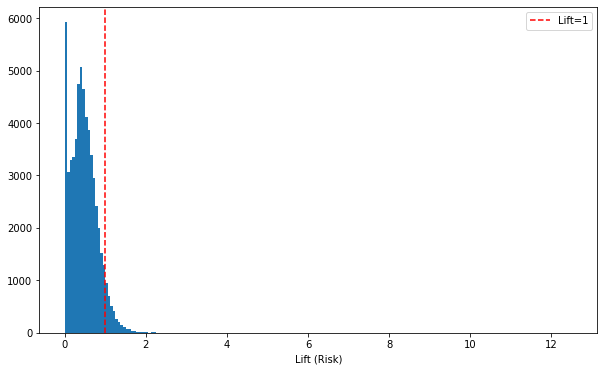

In [125]:
plt.figure(figsize=(10,6))
plt.hist(results.lift, 200)
plt.axvline(1, color='red', linestyle='--', label="Lift=1")
plt.xlabel('Lift (Risk)')
plt.legend()

We need to care about the points on the Right Tail (beyond Lift=1). We can set up custom thresholds to flag off risk vs non-risk situations to customize to a certain situation. A highly confidential dataset might need a much lower Lift threshold (ie close to 1) whereas in a low-risk dataset, we can flag Risky Scenarios to be datapoints with Lift > 2.

### CTGAN Comparison

In [3]:
#Load up datasets
original = pd.read_csv('./mortality_full_10k.csv')
ctgan = pd.read_csv('./mortality_full_10k_ctgan_v1.csv')
tgan = pd.read_csv('./mortality_full_10k_tgan_v1.csv')

#Round all numerical columns in TGAN dataset
tgan = tgan.apply(lambda x: round(x) if x.name in ['NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS'] else x)
tgan.head()

ctgan = ctgan.apply(lambda x: round(x) if x.name in ['NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS'] else x)
ctgan.head()

#Filtering for only columns needed 

#Storing the Subject ID ie. Patient ID for use in computing Internal Similarity
original_uid = original['SUBJECT_ID'].values

original = original[['ADMISSION_TYPE', 'MARITAL_STATUS',
       'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'GENDER', 'NUMCALLOUT',
       'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS']]


ctgan = ctgan[['ADMISSION_TYPE',
       'MARITAL_STATUS', 'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'GENDER',
       'NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS']]
tgan = tgan[['ADMISSION_TYPE',
       'MARITAL_STATUS', 'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'GENDER',
       'NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS']]

original.head()

#Prepare Data for PaR estimation
original_df_tgan, synth_df_tgan, col_mapping = prepData(original, tgan, col_list = None)

#Dispose the raw data to clear memory
del tgan

#Prepare Data for PaR estimation
original_df_ctgan, synth_df_ctgan, col_mapping = prepData(original, ctgan, col_list = None)

#Dispose the raw data to clear memory
del original, ctgan


18 columns levels were dropped because they were not observed in synthetic data 
1 columns levels were dropped because they were not observed in synthetic data 


In [44]:
results_ct, atrisk_ct, par_ct, time_ct = estimatePAR(original_df_ctgan, synth_df_ctgan, 1, original_uid=None, verbose=1)

External Similarities Completed: Time: 0:00:09.343777
Internal Similarities Completed: Time: 0:00:17.645556
Total Time:0:00:17.655331
Privacy At Risk: 8.05% 


We can observe that PaR with Distance Metrics tells a different story here. T-GAN PaR was 6.14% whereas CT-GAN PaR was 8.05%, considerably higher than the former.

#### TGAN protects privacy better than CTGAN

We can note that TGAN performs much better than CTGAN on the Privacy Risk side. TGAN Synthetic Data had a PaR value of 5.85% compared to 8.05% for the CTGAN generated Synthetic Data.

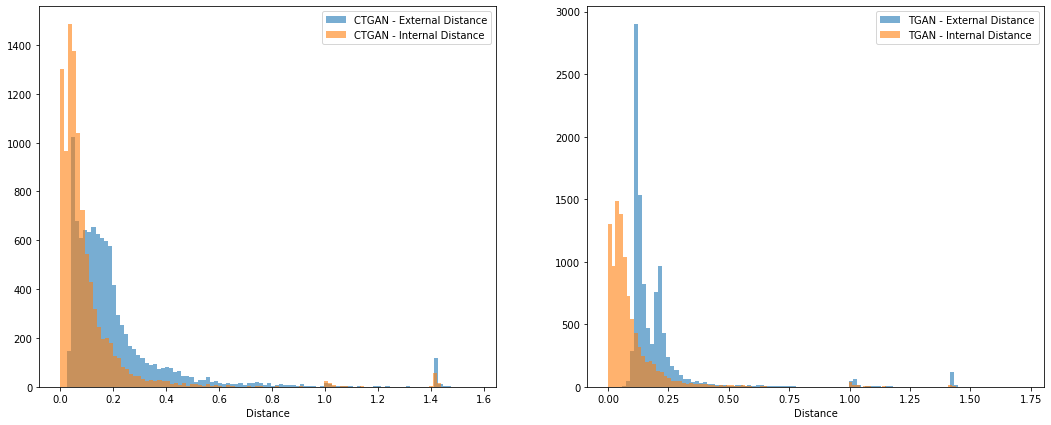

In [48]:
# risky_ct = results_ct[results_ct.closer==1]
# safe_ct = results_ct[results_ct.closer==0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(results_ct.synthetic, 100, alpha=0.6, label='CTGAN - External Distance')
ax1.hist(results_ct.within, 100, alpha=0.6, label="CTGAN - Internal Distance")
ax1.set_xlabel('Distance')
ax1.legend()
ax2.hist(results_t.synthetic, 100, alpha=0.6, label="TGAN - External Distance")
ax2.hist(results_t.within, 100, alpha=0.6, label="TGAN - Internal Distance")
ax2.set_xlabel('Distance')
ax2.legend()


In this visualization, we can also observe the seperation between the Internal and External Distances is much wider in the TGAN data compared to the CTGAN, which has considerable overlap between Internal and External Distances. The wider the Internal Distance and External Distances are seperated, the higher the amount of privacy as bad actors cannot find ground truth information based on similarity.



### Finding the Sensitive Columns

Users of a dataset often have an understanding of which columns are vulnerable to attacks. For example, Gender, Age and Zipcode are often potential sources used to join with other databases in order to mine information. But in a new dataset, there might always be other fields that we might not expect to be sensitive, but turn out to be sensitive in the way they make a person/record unique

So in our analysis, we compare the privacy at risk value before and after we drop a column (all levels if it's a categorical column). If the PaR increases after we drop the column, the decrease (lift) is attributed to the column that was dropped - meaning dropping a column decreases the Privacy At Risk by say 10%

In [11]:
results2, atrisk2, par2, time2 = estimatePAR(original_df, synth_df, 1, original_uid=None, verbose=1)

External Similarities Completed: Time: 0:06:13.676850
Internal Similarities Completed: Time: 0:11:46.179716
Total Time:0:11:46.246984
Privacy At Risk: 6.143176885512751% 


In [ ]:
def runSensitivityAnalysis(original_df, synth_df, original_uid, col_mapping, initialPAR):
    sensitivityDf = pd.DataFrame()
    sensitivityDf['column'] = col_mapping.keys()

    newPARs = []
    for x in col_mapping.keys():

        newColumns = []
        newCols = col_mapping.keys() - [x]
        for col in newCols:
            newColumns += col_mapping[col]

        x,y, par, time = estimatePAR(original_df[newColumns], synth_df[newColumns], 1, original_uid=None)
        newPARs.append(par)
        del x,y, par

    sensitivityDf['new_PAR'] = newPARs
    sensitivityDf['sensitivity_lift'] = (initialPAR - sensitivityDf['new_PAR'])*100/initialPAR
    
    return sensitivityDf
    
sens_df = runSensitivityAnalysis(original_df, synth_df, original_uid, col_mapping, 6.14317)   

In [15]:
sens_df['sensitivity_lift'] = (6.143 - sens_df['new_PAR'] )*100/6.143
sens_df.sort_values(by="sensitivity_lift", ascending=False)

,column,new_PAR,sensitivity_lift
1,MARITAL_STATUS,4.167797,30.070519
2,ETHNICITY,4.567960,23.356378
7,NUMDIAGNOSIS,4.801953,19.430313
4,GENDER,5.022382,15.731846
12,NUMPROC,5.057990,15.134401
13,NUMTRANSFERS,5.149552,13.598115
0,ADMISSION_TYPE,5.347938,10.269494
3,HOSPITAL_EXPIRE_FLAG,5.751492,3.498454
5,NUMCALLOUT,5.949878,0.169834
10,NUMPROCEVENTS,5.961747,-0.029315


### Intepreting the Sensitivity Lift Scores

We can see that Marital Status, Ethnicity and Number of Diagnoses have the highest Sensitivity Lift. A score of 30% means that including a column increases the Privacy At Risk Score by 30% ie. Including the MARITAL_STATUS field will increase the Privacy At Risk Score by 30%

We can also observe NUMINPUTEVENTS has a Sensitivity Lift of -90%. This means including the column reduces the Privacy Risky by 90%. This could be because Number of Input Events tracks every recorded event within the ICU and hence might be a random value not pertaining to a certain user thus increasing the confusion aspect.

**A useful tool in ascertaining necessity of certain features during data distribution**

Given that we know including fields such as Gender, Marital Status, Number of Diagnoses, we can use this information to take a quantitative decision on whether these information needs to be distributed. The stakeholders need to weigh the increase in PaR of 30% for including the Marital Status field versus the need for the Marital Status field to be consumed by Analysts.

### Removing At Risk points

Once we have understood which original datapoints are at risk, we can act on it by removing the synthetic data records that can potentially expose these points. We have access to the At Risk data points from the 'estimatePAR' function.


**Edge Case: One original person/record can have multiple synthetic datapoints very close to it**
We deal with this scenario by looking at all the synthetic datapoints that are closer to the original datapoint that the closest Within Distance for that datapoint (ie. Distance of Closest Other Original Record). We then remove all datapoints associated with the Risky Datapoints.


In [11]:
results = pd.read_csv('results-tgan.csv')
results.head()

,Unnamed: 0,synthetic,within,closer,lift
0,0,0.070816,0.013465,False,0.190141
1,1,0.065207,0.026632,False,0.408424
2,2,0.069628,0.006089,False,0.087455
3,3,0.064984,0.027990,False,0.430718
4,4,0.064515,0.033358,False,0.517061


In [12]:
atrisk = pd.read_csv('results-tgan-atrisk.csv')['atrisk'].values
atrisk

array([28626, 23278,  9981, ..., 30788,  1644, 22787], dtype=int64)

In [13]:
withinDistances = results.iloc[pd.read_csv('results-tgan-atrisk.csv')['atrisk'].values, 2:3]['within'].values
withinDistances

array([1.00158487, 1.01350409, 1.41741934, ..., 0.09605177, 0.08350501,
       0.11007349])

In [14]:
def removeRisk(original_df, synth_df, atrisk, top_remove, multipleCloseFlag=False, withins=None):
    
    #Set up a percentile for how many points you wanna remove : Eg: 10%
    n = round(len(atrisk)*top_remove/100)
    atrisk = atrisk[:n]
    
    riskyPoints = original_df.iloc[atrisk, :]
    
    synth_risks = []
    
    distances = pairwise_distances(np.asarray(riskyPoints), np.asarray(synth_df))     
    
    if multipleCloseFlag == False:
        for i in range(0, len(atrisk)):
            synth_risks += list(np.where(distances[i] == np.amin(distances))[0])
    else:
        for i in range(0, len(atrisk)):
            synth_risks += list(np.where(distances[i] < withins[i])[0])
        
    estimatePAR(original_df, synth_df.drop(synth_risks), 1, None, verbose=1)
    
    return synth_df.drop(synth_risks)

In [16]:
newsynth = removeRisk(original_df, synth_df, atrisk, 100, True, withinDistances)

External Similarities Completed: Time: 0:05:30.299798
Internal Similarities Completed: Time: 0:11:14.052077
Total Time:0:11:14.485657
Privacy At Risk: 0.0% 


In [17]:
newsynth.to_csv('new_synthetic_tgan.csv')

We can see that PaR has now decreased to 0%! This is because we set the top_remove percent to be 100% ie. Remove all synthetic datapoints associated with the original records put at risk. But zero Privacy Risk might not always mean good for us. 


## Conclusions

We have come up with a clear framework on how Optum can go about measuring the risks associated with Synthetic Datasets, and few tools to assess and reduce the risks involved with T-GAN/CT-GAN generated Synthetic Data

#### Exact Matches Risk Measurement

Synthetic Data, from both T-GAN and CT-GAN reported 0% exact matches. Both models performed well on this front.

#### Closest Matches

On average, every original datapoint's closest neighbor in T-GAN dataset/CT-GAN dataset had 9 (out of 37) columns different. This is reassuring as even the closest neighbor in synthetic dataset was significantly different, but setting thresholds is difficult.

#### PaR 

In the PaR (with column matches) approach, T-GAN reported a PaR of 1.02% and CT-GAN 0.62%.

In the PaR (with distance metrics) approach, T-GAN reported a PaR of 6.14% whereas CT-GAN was 8.05%

#### PaR is a very conservative metric

Significant differences still exists in the synthetic data, even though PaR may indicate a much higher privacy risk / number of records that could potentially be exposed. PaR should be recommended as a conservative metric, that prepares for the worst case scenario with respect to exposure.

#### T-GAN vs CT-GAN

T-GAN and CT-GAN were comparable in the Exact Matches, Closest Matches and PaR (with column matches) approaches. T-GAN outperformed CT-GAN data in the PaR with Distance Metrics scenario, with T-GAN PaR 2% lower.

#### Complexity of Risk Measurement based on Scenario

The Risk Measurement should be tailored to the scenario after assessing the sophistication of bad actors, and the level of privacy the use case requires.
1. Choose approach (Exact Matches to PaR with Distance Metrics) on the Roadmap chart based on parameters
2. Use Lift Charts to tailor the way PaR is measured based on situation. Setting a lower Lift threshold would result in larger number of Risky points, and is hence more conservative.

#### Risk Removal

The Risk Removal module can be used to lower the number of Risky Synthetic Datapoints. T-GAN PaR was brough down to 0% using the module, but Utility suffered

#### Column Sensitivity Analysis

PaR module can be used to understand the sensitivity of columns in a dataset, without much background information. The sensitivity values reflected common intuition, with features like Gender, Ethnicity having a strong Sensitivity Lift ie. including such columns increased the PaR





## Miscellaneous Notes on Privacy Risk Module

### Tradeoff between Utility and Privacy

There is always a tradeoff whenever we remove datapoints from the synthetic datapoints. At the cost of improving the Privacy, we will sacrifice some utility with respect to the dataset. We can experiment with the top_remove parameter, which decides what % of the Risky Datapoints will be dealt with - We can observe the new PaR values on de-exposing 10% of Risky Datapoints, 50% of Risky Datapoints and so on.

An understanding of what is the accepted level of Privacy and Utility is required to make decisions here on which synthetic data generation process works best for the situation.

### Using Lift values to remove data points

Another useful metric to base the decision of removing synthetic datapoints can be based on the sensitivity_lift parameter. This is a ratio of the Within Distance and the External Distance. A higher ratio means a higher risk of a certain datapoint being exposed. This requires intervention from the stakeholders as to what should be the right threshold ie. De-expose original datapoints having a Sensitivity Lift value above 2

### Scalability of the Module

The Privacy Risk module at this stage is computationally expensive. Multiple Cross-Joins are required between the Original and Synthetic Datasets through the PaR Estimation, Sensitivity Analysis and the Privacy Risk Removal parts.

1. **Privacy At Risk Estimation**

The PaR Estimation (estimatePAR) function performs two cross joins and hence is a function of the dataset size. In Big-O notation, the Order of the Function would be:  O(2 x n<sup>2</sup>). 

With a dataset size of 58,000 rows, the PaR module ran for 10:53 minutes on the AWS setup without handling for Patient Journey Edge Cases (multiple records per patient). Handling for the Patient Journey case, the PaR module took ~4 hours.

2. **Feature Sensitivity Analysis**

This is the most time-consuming module. The Order of the runSensitivityAnalysis is of the magnitude O(K x n<sup>2</sup>) in Big-O notation; K being the number of columns (33 here). It's in additinally proportional to the number of columns to test, apart from the square of the dataset size, in terms of time complexity.

Without handling for the Patient Journey use case, the Feature Sensitivity Analysis will on average run for about 6 hours. While handling the edge case, the time to run quickly jumps up to 5.5 days.

3. **Removal of Risky Datapoints**

This is comparable to the Privacy At Risk Estimation, as we have one simple cross-join on a subset of the data and a Privacy At Risk Estimation at the end to assess the improvement. Time to run the module is comparable to PaR Estimation.


### Future Steps

1. **Improving the Scalability of the Privacy Risk Module**

The module is currently highly time and resource intensive. More parallelization of the functions can result in significant reduction of the time complexity.

2. **Connect the Privacy Risk and Utility Modules to automate decisions on trade-off**

By connecting the two modules, we will be able to run multiple iterations to understand what is the best balance between Privacy Risk and Utility that can be achieved through the Synthetic Data Generation Process. A requirement for this would be to reduce the time complexity of the module, so that we can perform multiple iterations at scale.

3. **Integration of Differential Privacy Metrics**

Integrating Differential Privacy into both the Synthetic Data Generation process and the metric for evaluation can be a promising path for the project. Differential Privacy provides mathematical guarantees on the privacy of a dataset and the potential for re-identifying individuals within a dataset. DP-GAN is still in a nascent stage and is not compatible with Tabular Data as of now. Further exploration could be in this direction.
